In [201]:
from typing import Dict, List, Tuple, Union
from gym import Space, spaces
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from env import PrisonersDilemmaEnv
import utils
from importlib import reload
reload(utils)

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (8, 4)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

### Run experiments [standard]

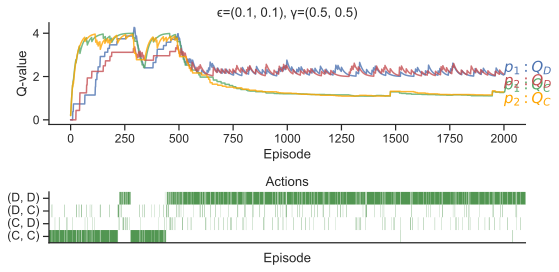

In [208]:
# Setup config
config = {
    'num_simuls': 1,
    'num_episodes': 2000,
    'num_agents': 2,
    'num_actions': 2,
    'verbose': False,
    'init_type':'zeros',
}

config['params'] = {
    'alpha': np.array([0.1, 0.1]),
    'eps': np.array([0.1, 0.1]),
    'gamma': np.array([0.5, 0.5]),
}

# Run experiments
q_traj_one, q_traj_two, rewards_seq, action_seq = utils.run_standard_ipd_exp(config)

# Visualize trajectories and actions
utils.make_q_vals_fig(
    num_simuls=config['num_simuls'],
    action_seq=action_seq,
    config=config,
    q_traj_one=q_traj_one,
    q_traj_two=q_traj_two,
    )

### Run experiments [with information passing]

In [ ]:
game_env = PrisonersDilemmaEnv()

# Initialize Q-tables
q_table_one, q_table_two = utils.init_q_tables(init_type='zeros', env=game_env)

q_traj_one = np.zeros((config['num_episodes'], game_env.action_space.n))
q_traj_two = np.zeros((config['num_episodes'], game_env.action_space.n))
rewards_seq = np.zeros((config['num_episodes'], config['num_agents']))
action_seq = np.zeros((config['num_episodes'], config['num_agents']))


for episode_i in range(config['num_episodes']):
    
    if config['verbose']: print(f'Episode: {episode_i}')

    # Player one: take random action
    if np.random.random() < config['params']['eps'][0]:
        act_play_one = np.array([game_env.action_space.sample()])
    else: # Exploit
        act_play_one = np.random.choice(
            a=np.argwhere((q_table_one == q_table_one.max())).flatten(),
            size=(1,)
        )
    
    # Player two: take random action
    if np.random.random() < config['params']['eps'][1]:
        act_play_two = np.array([game_env.action_space.sample()])    
    else: # Exploit
        act_play_two = np.random.choice(
            a=np.argwhere((q_table_two == q_table_two.max())).flatten(),
            size=(1,)
        )

    # Take a step 
    actions = np.concatenate([act_play_one, act_play_two])
    _, rewards, _, _, _ = game_env.step(action=actions)

    # Update Q-values
    q_table_one[act_play_one] = q_table_one[act_play_one] + \
        config['params']['alpha'][0] * (rewards[0] + config['params']['gamma'][0] * np.max(q_table_one) - q_table_one[act_play_one])

    q_table_two[act_play_two] = q_table_two[act_play_two] + \
        config['params']['alpha'][1] * (rewards[1] + config['params']['gamma'][1] * np.max(q_table_two) - q_table_two[act_play_two])


    # Store trajectory
    rewards_seq[episode_i, :] = rewards
    action_seq[episode_i, :] = actions
    # episode x actions x players
    q_traj_one[episode_i] = q_table_one
    q_traj_two[episode_i] = q_table_two